In [ ]:
# resources
#thanks Pankaj for providing a startting notebook
#https://github.com/Pankaj1357

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# install packages

In [3]:
%%capture
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics
!pip install segmentation-models-pytorch
!pip install --upgrade albumentations
!pip install onnx
!pip install onnxruntime

In [4]:
import albumentations as A
A.__version__ 

'1.0.2'

In [5]:
import pytorch_lightning as PL
PL.__version__

'1.3.8'

# download and extract data

In [6]:
%%capture
import os
if os.path.isfile('training_set.zip') is False:
  !wget https://zenodo.org/record/1327317/files/training_set.zip
  !wget https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv
  !wget https://zenodo.org/record/1327317/files/test_set_pixel_size.csv
  !wget https://zenodo.org/record/1327317/files/test_set.zip

In [7]:
%%capture
!unzip /content/training_set.zip
!unzip /content/test_set.zip

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [17]:
train_df=pd.read_csv('/content/training_set_pixel_size_and_HC.csv')
train_df.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [18]:
test_df=pd.read_csv('/content/test_set_pixel_size.csv')
test_df.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


Text(0.5, 1.0, 'Image Annotation')

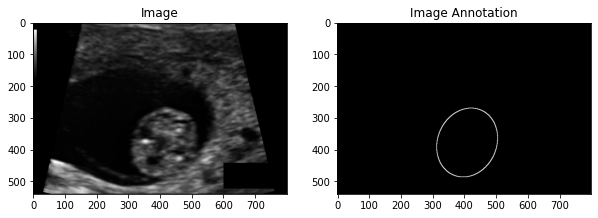

In [19]:
img=cv2.imread('/content/training_set/000_HC.png',0)
img_annot=cv2.imread('/content/training_set/000_HC_Annotation.png',0)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(img_annot,cmap='gray')
ax[1].set_title('Image Annotation')


In [167]:
#convert this circle to a mask
def masking(image):
    ret, thresh = cv2.threshold(image, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

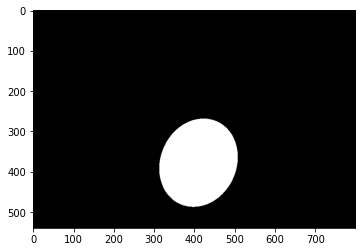

In [168]:
img=cv2.imread('/content/training_set/000_HC_Annotation.png',0)
plt.imshow(masking(img),cmap='gray')

## <font color='red'> run following cell one time only </font>

In [22]:
#do this will all images annotation
images_path,mask_path=[],[]
for img_path in sorted(glob('/content/training_set/*.png')):
  if 'Annotation' in img_path:
    mask_path.append(img_path)#get path of all masks
    image=cv2.imread(img_path,0)
    image=masking(image)
    cv2.imwrite(img_path, image)
  else:
    images_path.append(img_path)#get path of all images
    


Text(0.5, 1.0, 'Image Annotation')

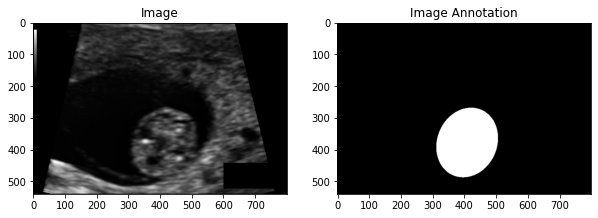

In [23]:
img=cv2.imread('/content/training_set/000_HC.png',0)
img_annot=cv2.imread('/content/training_set/000_HC_Annotation.png',0)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(img_annot,cmap='gray')
ax[1].set_title('Image Annotation')


In [24]:
len(images_path),len(mask_path)

(999, 999)

# image augmentation

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

aug= A.Compose([
            A.Resize(224, 224),
            #CenterCrop(224,224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(60), 
            #A.ShiftScaleRotate(2,2,5), 
            #A.Cutout(p=0.5),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

# creater loader

In [26]:
from torch.utils.data import DataLoader, Dataset
import torchvision

In [27]:
class Reader(Dataset):
  def __init__(self,images,labels,transform=None):
    super(Reader,self).__init__()
    self.images=images
    self.masks=labels
    self.transform=transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,index):
    image_path=self.images[index]
    mask_path=self.masks[index]

    image=cv2.imread(image_path,0)
    mask=cv2.imread(mask_path,0)
    if self.transform:
      transformed =self.transform(image=image,mask=mask)
      image=transformed['image']
      mask=transformed['mask']
      mask=np.expand_dims(mask,0)//255

    return image,mask


torch.Size([8, 1, 224, 224]) torch.Size([8, 1, 224, 224])


Text(0.5, 1.0, 'batch of masks')

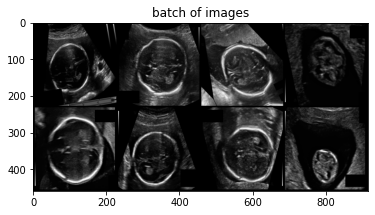

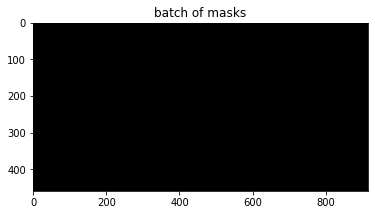

In [28]:
#testing above code
batch=next(iter(DataLoader(Reader(images_path,mask_path,aug), batch_size = 8, num_workers=1,shuffle=True)))
print(batch[0].shape,batch[1].shape)
plt.figure()
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('batch of images')
plt.figure()
grid_img=torchvision.utils.make_grid(batch[1],4,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('batch of masks')


In [29]:
# model = smp.Unet(
#                 encoder_name='resnet18',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#                 encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#                 in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#                 classes=1,    # model output channels (number of classes in your dataset)
#                 activation='sigmoid'    # could be None for logits or 'softmax2d' for multiclass segmentation               
# )

In [30]:
# x=torch.randn(1,1,224,224)
# y=torch.randn(1,1,224,224)

# out=model(x)
# print(out.shape)

In [31]:
# metrics = smp.utils.metrics.IoU(threshold=0.5)
# metrics(y,out)

#create model setup

In [32]:
from sklearn.model_selection import train_test_split
train_images,val_images,train_masks,val_masks=train_test_split(images_path,mask_path,test_size=0.2,random_state=21)

In [33]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import segmentation_models_pytorch as smp
import torchmetrics

import torch.nn as nn
import torch

In [34]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name='resnet18',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=1,    # model output channels (number of classes in your dataset)
                activation='sigmoid'    # could be None for logits or 'softmax2d' for multiclass segmentation               
)


  #parameters
    self.lr=1e-3
    self.batch_size=24
    self.numworker=2
    self.criterion= smp.utils.losses.DiceLoss()
    self.metrics = torchmetrics.IoU(num_classes=2)
    
  def forward(self,x):
    #print(x.max(),x.min())
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = Reader(train_images,train_masks,aug)
    loader = DataLoader(ds, batch_size=self.batch_size)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = Reader(val_images,val_masks,aug)
    loader = DataLoader(ds, batch_size=self.batch_size)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)
    iou=self.metrics(out.type(torch.long),segment.type(torch.long))
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/iou', iou, on_epoch=True,prog_bar=True)
    return loss

In [35]:
model = OurModel()
logger = TensorBoardLogger("logs", name="my_logs")
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='ultrasound' )
trainer = Trainer(max_epochs=1500, auto_lr_find=False, auto_scale_batch_size=False,
                  #resume_from_checkpoint='/content/drive/MyDrive/ultrasound.ckpt',
                  tpu_cores=8,precision=16,
                  logger=logger,
                  callbacks=[checkpoint_callback],
                  progress_bar_refresh_rate=60)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores


In [ ]:
trainer.fit(model)

In [38]:
test_loader=model.val_dataloader()
model.eval()
with torch.no_grad():
  imgs,preds,labels=[],[],[]
  for img, seg in test_loader:
    pred=model(img)
    img=img.detach().numpy()
    pred=pred.detach().numpy()
    seg=seg.detach().numpy()
    imgs.append(img)
    preds.append(pred)
    labels.append(seg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [39]:
img.shape,pred.shape,seg.shape


((8, 1, 224, 224), (8, 1, 224, 224), (8, 1, 224, 224))

In [40]:
imgs_array=np.concatenate(imgs)
preds_array=np.concatenate(preds)
labels_array=np.concatenate(labels)
imgs_array.shape,preds_array.shape,labels_array.shape

((200, 1, 224, 224), (200, 1, 224, 224), (200, 1, 224, 224))

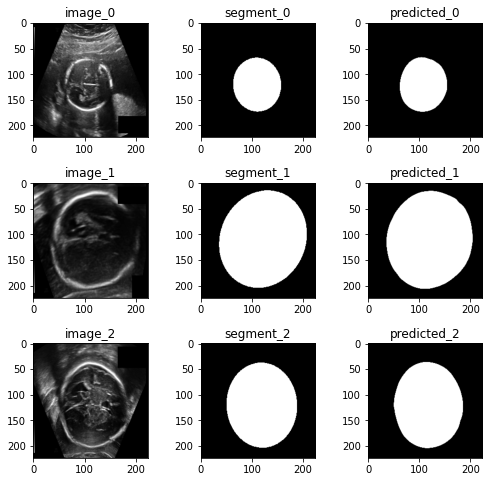

In [41]:
fig,ax=plt.subplots(3,3,figsize=(16,8))
for i in range(3):
  ax[i,0].imshow(imgs_array[i,0,:,:],cmap='gray')
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(labels_array[i,0,:,:],cmap='gray')
  ax[i,1].set_title('segment_{}'.format(i))
  ax[i,2].imshow(preds_array[i,0,:,:],cmap='gray')
  ax[i,2].set_title('predicted_{}'.format(i))
plt.subplots_adjust(wspace=-0.7, hspace=0.4)

In [42]:
print(labels_array.reshape(200,-1).shape,preds_array.reshape(200,-1).shape)

(200, 50176) (200, 50176)


In [43]:
import torchmetrics
pred=torch.tensor(preds_array.astype(int))
target=torch.tensor(labels_array)

iou=torchmetrics.IoU(num_classes=2)
iou(pred,target)

tensor(0.6359)

# save to onnx

In [34]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ultrasound_state.pt')


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ultrasound_state.pt'))

In [44]:
filepath = '/content/drive/MyDrive/ultrasound.onnx'
input_sample = torch.randn((1,1, 224,224))
model.to_onnx(filepath,input_sample, export_params=True)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:375: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


# onnx testing


In [1]:
import onnxruntime
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

ort_session = onnxruntime.InferenceSession("/content/drive/MyDrive/ultrasound.onnx")


In [2]:
def normalize(img, mean=0, std=1, max_pixel_value=255.0):
    mean = np.array(mean, dtype=np.float32)
    mean *= max_pixel_value

    std = np.array(std, dtype=np.float32)
    std *= max_pixel_value

    denominator = np.reciprocal(std, dtype=np.float32)

    img = img.astype(np.float32)
    img -= mean
    img *= denominator
    return img

In [6]:
def predict(img_path):
  img = cv2.imread(img_path,0)
  image=cv2.resize(img,(224,224))
  img=normalize(np.array(image))#shape is (224,224)
  img=np.expand_dims(img,0)#shape is (1,224,224)
  img=np.expand_dims(img,0)#shape is (1,1,224,224)
  ort_inputs = {ort_session.get_inputs()[0].name: img}
  ort_outs = ort_session.run(None, ort_inputs)
  img_out_y = ort_outs[0]
  img_out_y=img_out_y[0,0,:,:]
  return img_out_y,image

In [7]:
img_out_y,image=predict("/content/training_set/000_HC.png")

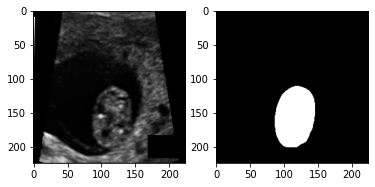

In [8]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(image,cmap='gray')
ax[1].imshow(img_out_y,cmap='gray')

# final submission

In [9]:
import pandas as pd 
test=pd.read_csv('/content/test_set_pixel_size.csv')
test.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [10]:
def test_ellipse(img):   
    img=(img*255).astype(np.uint8) 
    ret,thresh = cv2.threshold(img,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [11]:
def create_vals(ellipse,pixel_size):
  center_x,  center_y = ellipse[0]
  center_x_mm=pixel_size*center_x
  center_y_mm=pixel_size*center_y
  semi_axes_b, semi_axes_a = ellipse[1]
  if semi_axes_b > semi_axes_a:
      semi_axes_b = semi_axes_b + semi_axes_a
      semi_axes_a = semi_axes_b - semi_axes_a
      semi_axes_b -= semi_axes_a
  semi_axes_a_mm=semi_axes_a*pixel_size/2
  semi_axes_b_mm=semi_axes_b*pixel_size/2
  angle = ellipse[2]
  if angle < 90:
      angle += 90
  else:
      angle -= 90
  angle_rad=np.deg2rad(angle)
  return center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad

In [12]:
file_name,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad=[],[],[],[],[],[]
for i in range(len(test)):
  test_img_path,test_img_pixel=test.filename[i],test.loc[i,'pixel size(mm)']
  img_out_y,_=predict("/content/test_set/{}".format(test_img_path))
  ellipse=test_ellipse(img_out_y)
  #im_mask = cv2.ellipse(np.zeros_like(img),ellipse,(255,255,255),-1)
  a,b,c,d,e=create_vals(ellipse,test_img_pixel)
  center_x_mm.append(a)
  center_y_mm.append(b)
  semi_axes_a_mm.append(c)
  semi_axes_b_mm.append(d)
  angle_rad.append(e)
  file_name.append(test_img_path)

In [13]:
sub_df=pd.DataFrame(zip(file_name,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad),
                    columns=['file_name','center_x_mm','center_y_mm','semi_axes_a_mm','semi_axes_b_mm','angle_rad'])

In [14]:
sub_df.head()

,file_name,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,26.451087,26.986599,17.030828,14.807997,1.725138
1,001_HC.png,8.399043,8.895225,4.388064,3.404638,1.574639
2,002_HC.png,16.979112,17.548344,12.068197,10.561689,1.559943
3,003_HC.png,9.635919,11.472000,9.440658,8.531018,1.796839
4,004_HC.png,22.722491,24.410436,17.865581,15.877497,1.482992


In [15]:
sub_df.to_csv('sub.csv',index=False)

In [14]:
!rm -rf /content/training_set
!rm -rf /content/test_set